In [154]:
#import spiceypy
%reset
from scipy import stats
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from pathlib import Path
import seaborn as sns
import pprint
import json
import rebound

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


- https://pdssbn.astro.umd.edu/data_other/objclass.shtml
- https://minorplanetcenter.net/Extended_Files/Extended_MPCORB_Data_Format_Manual.pdf
- https://minorplanetcenter.net/iau/MPC_Documentation.html

In [35]:
df = pd.read_json('mpcorb_extended.json')
pd.set_option('display.max_columns', None)
df.head()

,H,G,Num_obs,rms,U,Arc_years,Perturbers,Perturbers_2,Number,Name,Principal_desig,Other_desigs,Epoch,M,Peri,Node,i,e,n,a,Ref,Num_opps,Computer,Hex_flags,Last_obs,Tp,Orbital_period,Perihelion_dist,Aphelion_dist,Semilatus_rectum,Synodic_period,Orbit_type,NEO_flag,One_km_NEO_flag,PHA_flag,Critical_list_numbered_object_flag,One_opposition_object_flag,Arc_length
0,3.32,0.15,7259.0,0.65,0,1801-2022,M-v,30l,(1),Ceres,A801 AA,"[A899 OF, 1943 XB]",2459800.5,334.32723,73.53158,80.26642,10.58680,0.078636,0.214181,2.766619,E2022-SB7,123,MPCLINUX,0000,2022-09-16,2.459920e+06,4.601761,2.549064,2.984174,1.374756,1.277642,MBA,NaN,NaN,NaN,NaN,NaN,NaN
1,4.12,0.15,8871.0,0.59,0,1804-2022,M-c,28k,(2),Pallas,A802 FA,NaN,2459800.5,315.09111,310.84262,172.91791,34.92715,0.229986,0.213851,2.769463,MPO710565,120,MPCLINUX,0000,2022-08-04,2.460011e+06,4.608859,2.132524,3.406402,1.311488,1.277096,MBA,NaN,NaN,NaN,NaN,NaN,NaN
2,5.14,0.15,7411.0,0.63,0,1804-2022,M-v,3El,(3),Juno,A804 RA,NaN,2459800.5,306.62242,247.80396,169.84591,12.99223,0.256775,0.225857,2.670422,E2022-U28,113,MPCLINUX,0000,2022-10-16,2.460037e+06,4.363851,1.984725,3.356120,1.247176,1.297278,MBA,NaN,NaN,NaN,NaN,NaN,NaN
3,3.20,0.15,7508.0,0.63,0,1821-2022,M-p,18l,(4),Vesta,A807 FA,NaN,2459800.5,61.19232,151.25772,103.80084,7.14078,0.088402,0.271511,2.361987,E2022-T39,108,MPCLINUX,0000,2022-09-23,2.459575e+06,3.630081,2.153183,2.570791,1.171764,1.380216,MBA,NaN,NaN,NaN,NaN,NaN,NaN
4,7.02,0.15,3099.0,0.72,0,1845-2022,M-v,3El,(5),Astraea,A845 XA,[1969 SE],2459800.5,208.56769,358.79230,141.56759,5.36542,0.188985,0.238175,2.577540,E2022-U63,85,MPCLINUX,0000,2022-10-13,2.460436e+06,4.138168,2.090423,3.064657,1.242741,1.318657,MBA,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df.dropna()
#Evaluate MSB. Convert it to identify PHA
df['Hex_flags']='0x' + df['Hex_flags'].astype('string')
df['Hex_flags'] = df['Hex_flags'].apply(lambda x: int(x, 16))
df['Hex_flags'] = df['Hex_flags'].apply(lambda x: 1 if (x >= 32768) else 0)

In [37]:
df.Orbit_type.unique()

array(['MBA', 'Phocaea', 'Object with perihelion distance < 1.665 AU',
       'Hilda', 'Amor', 'Hungaria', 'Jupiter Trojan', 'Apollo',
       'Distant Object', 'Aten', 'Atira'], dtype=object)

In [38]:
#removed useless fields and rename others
df.drop(['NEO_flag','Critical_list_numbered_object_flag','One_opposition_object_flag'], axis=1, inplace=True)
df.drop(['One_km_NEO_flag','Computer','Number','U'], axis=1, inplace=True)
df.drop(['Ref','Arc_length','Tp','Num_opps','Perturbers_2','Perturbers','n'], axis=1, inplace=True)
df.rename(columns={"Perihelion_dist": "q", "Aphelion_dist": "Q"}, inplace=True)
df["Orbit_type"].replace({"Object with perihelion distance < 1.665 AU": "q < 1.665 AU"}, inplace=True)

<IPython.core.display.Javascript object>


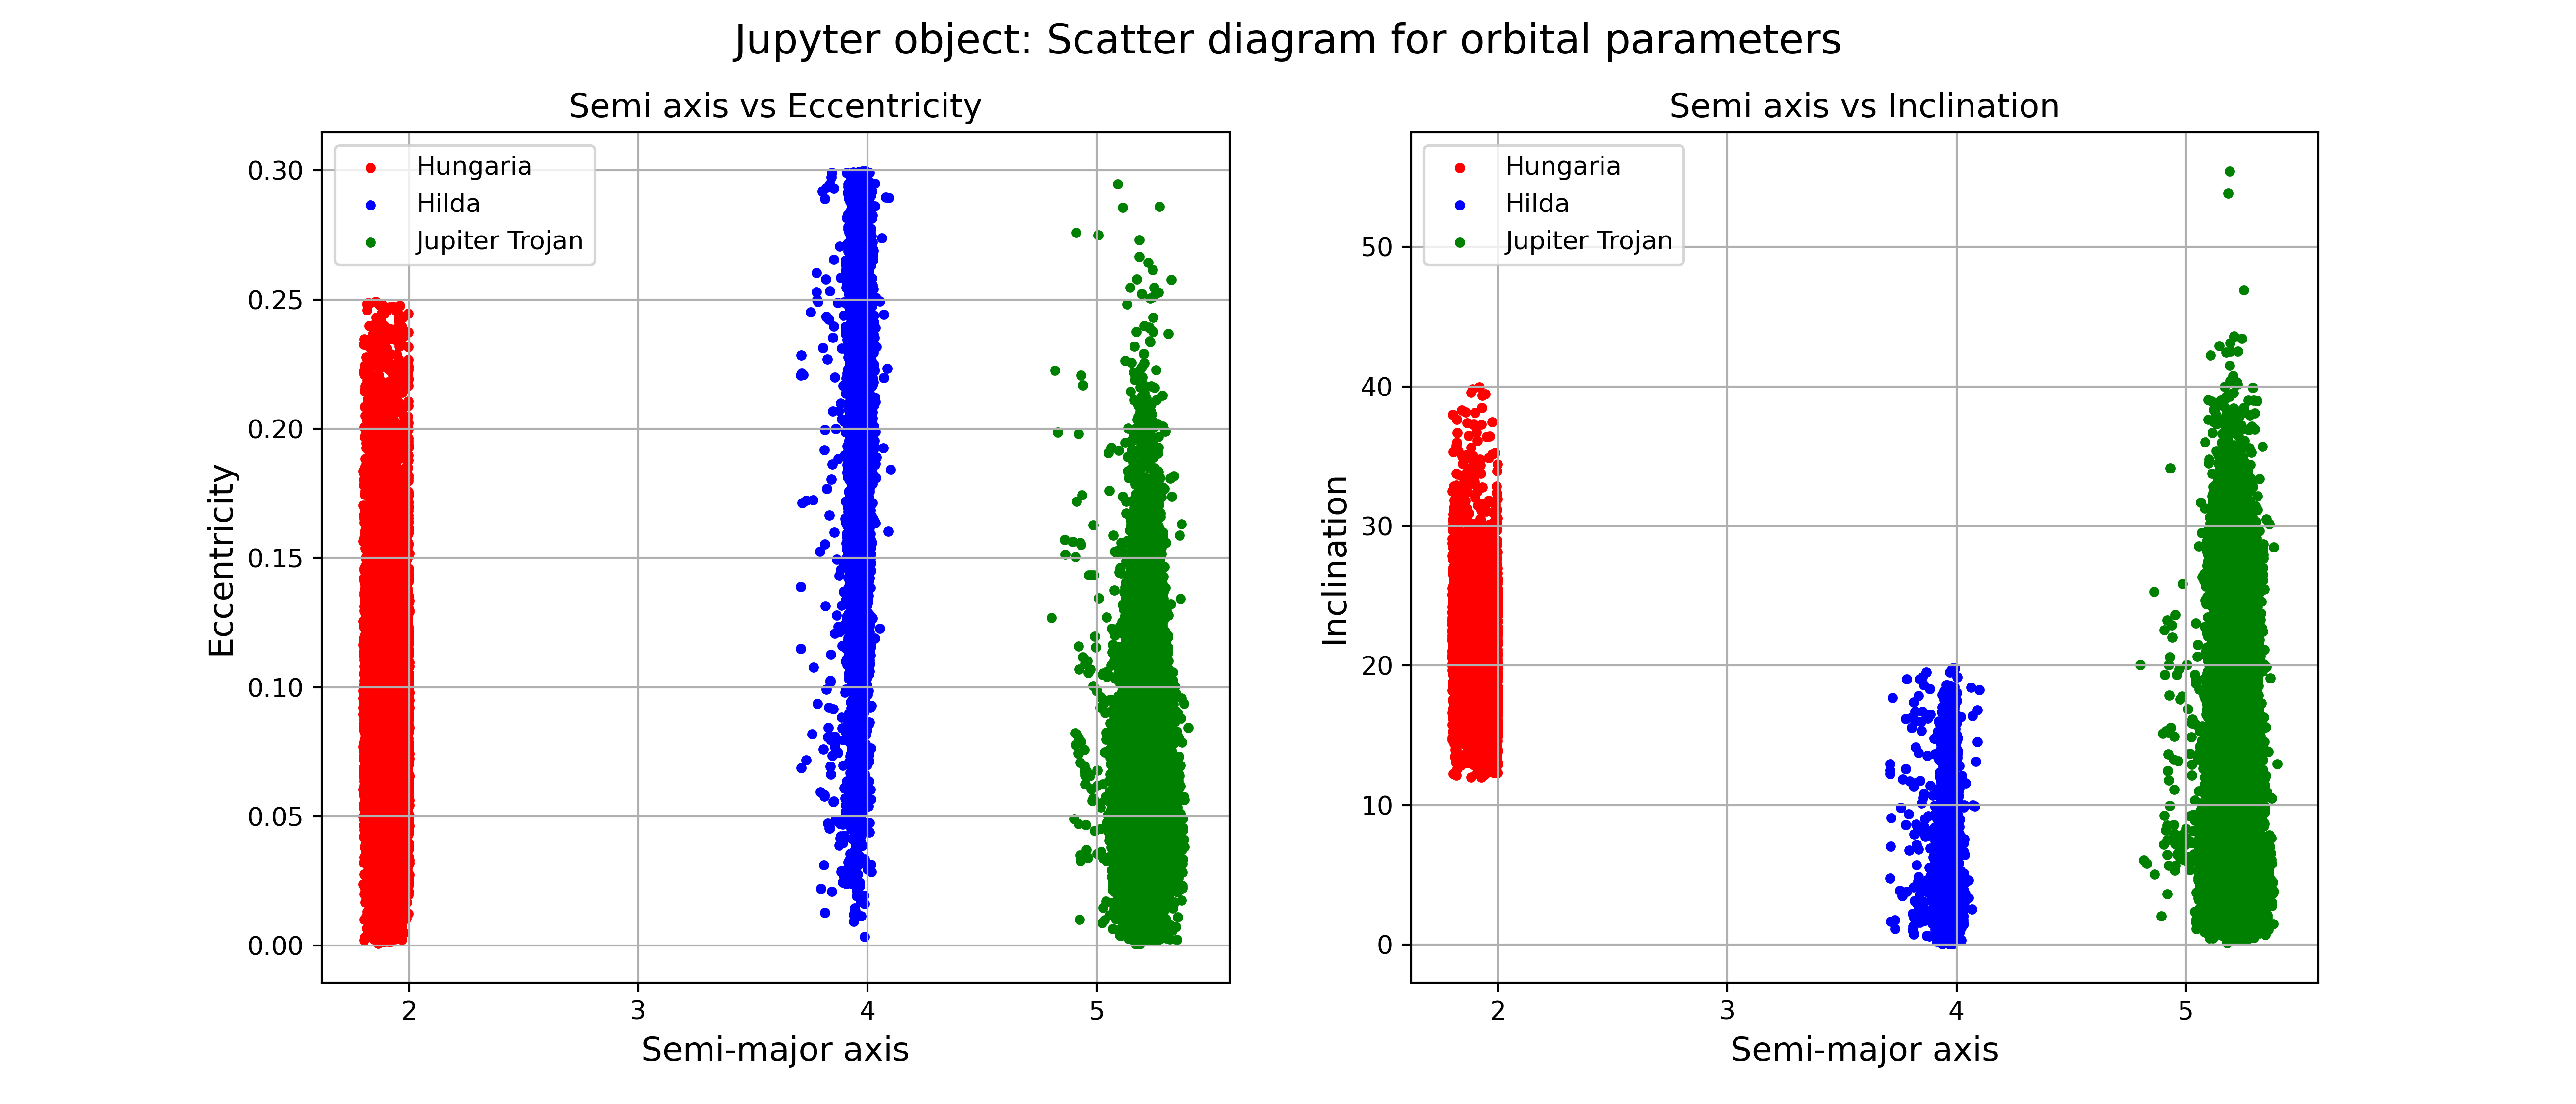

In [39]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

fig.suptitle('Jupyter object: Scatter diagram for orbital parameters', fontsize=16)

MPC_Jupyter_Hungaria_a = df.apply(lambda row: row[df['Orbit_type'].isin(['Hungaria'])])['a']
MPC_Jupyter_Hilda_a = df.apply(lambda row: row[df['Orbit_type'].isin(['Hilda'])])['a']
MPC_Jupyter_Trojan_a = df.apply(lambda row: row[df['Orbit_type'].isin(['Jupiter Trojan'])])['a']

MPC_Jupyter_Hungaria_e = df.apply(lambda row: row[df['Orbit_type'].isin(['Hungaria'])])['e']
MPC_Jupyter_Hilda_e = df.apply(lambda row: row[df['Orbit_type'].isin(['Hilda'])])['e']
MPC_Jupyter_Trojan_e = df.apply(lambda row: row[df['Orbit_type'].isin(['Jupiter Trojan'])])['e']

MPC_Jupyter_Hungaria_i = df.apply(lambda row: row[df['Orbit_type'].isin(['Hungaria'])])['i']
MPC_Jupyter_Hilda_i = df.apply(lambda row: row[df['Orbit_type'].isin(['Hilda'])])['i']
MPC_Jupyter_Trojan_i = df.apply(lambda row: row[df['Orbit_type'].isin(['Jupiter Trojan'])])['i']

ax1.set_title('Semi axis vs Eccentricity', fontsize=13)
x = ax1.scatter(MPC_Jupyter_Hungaria_a, MPC_Jupyter_Hungaria_e, color='r', marker=".", label="Hungaria")
y = ax1.scatter(MPC_Jupyter_Hilda_a, MPC_Jupyter_Hilda_e, color='b', marker=".", label="Hilda")
z = ax1.scatter(MPC_Jupyter_Trojan_a, MPC_Jupyter_Trojan_e, color='g', marker=".", label="Jupiter Trojan")
ax1.set_xlabel("Semi-major axis", fontsize=13)
ax1.set_ylabel("Eccentricity", fontsize=13)
ax1.legend()
ax1.grid()

ax2.set_title('Semi axis vs Inclination', fontsize=13)
x_2 = ax2.scatter(MPC_Jupyter_Hungaria_a, MPC_Jupyter_Hungaria_i, color='r', marker=".", label="Hungaria")
y_2 = ax2.scatter(MPC_Jupyter_Hilda_a, MPC_Jupyter_Hilda_i, color='b', marker=".", label="Hilda")
z_2 = ax2.scatter(MPC_Jupyter_Trojan_a, MPC_Jupyter_Trojan_i, color='g', marker=".", label="Jupiter Trojan")
ax2.set_xlabel("Semi-major axis", fontsize=13)
ax2.set_ylabel("Inclination", fontsize=13)
ax2.legend()
ax2.grid()

#fig.savefig('jupyter_object_semi_major_axis.png', dpi=600)

In [6]:
MPC_Jupyter_H = df.apply(lambda row: row[df['Orbit_type'].isin(['Hungaria','Hilda','Jupiter Trojan'])])
MPC_Jupyter_no_outliers = MPC_Jupyter_H[MPC_Jupyter_H['H'] < (10 * MPC_Jupyter_H['H'].std())] 

<IPython.core.display.Javascript object>


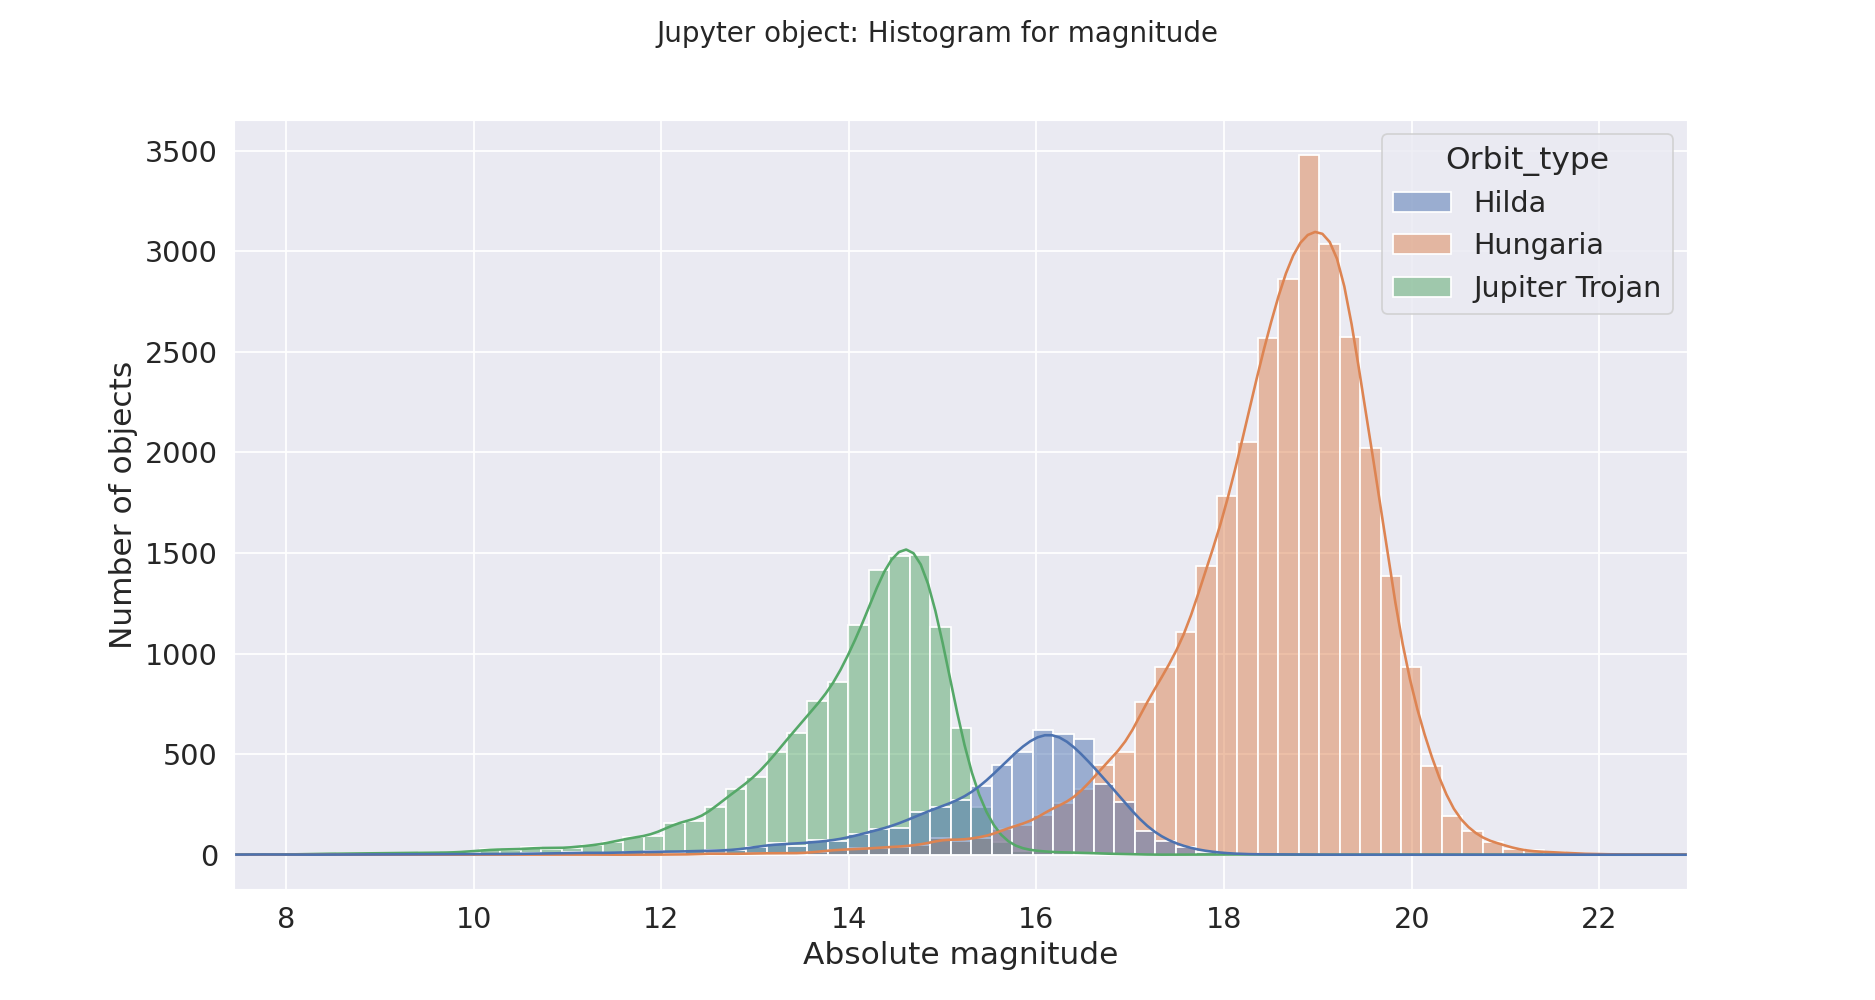

Text(0.5, 0.98, 'Jupyter object: Histogram for magnitude')

In [40]:
sns.set_theme()
sns.set(font_scale=1.5)  
plt.figure(figsize=(15,8))
p = sns.histplot(data=MPC_Jupyter_no_outliers, x="H", kde=True, hue="Orbit_type")
p.set(xlabel="Absolute magnitude", ylabel = "Number of objects")
plt.xlim([MPC_Jupyter_no_outliers.H.min(), MPC_Jupyter_no_outliers.H.max()])
plt.suptitle('Jupyter object: Histogram for magnitude', fontsize=16)

#fig.savefig('jupyter_object_absolute_magnitude.png', dpi=600)

In [41]:
MPC_Jupyter_no_outliers_Hilda = MPC_Jupyter_no_outliers[MPC_Jupyter_no_outliers['Orbit_type'] =='Hilda']
MPC_Jupyter_no_outliers_Hilda.head()

,H,G,Num_obs,rms,Arc_years,Name,Principal_desig,Other_desigs,Epoch,M,Peri,Node,i,e,a,Hex_flags,Last_obs,Orbital_period,q,Q,Semilatus_rectum,Synodic_period,Orbit_type,PHA_flag
152,7.67,0.15,3868.0,0.60,1880-2022,Hilda,A875 VC,[1935 GD],2459800.5,323.99445,39.40652,228.08895,7.82771,0.139723,3.975533,0,2022-09-09,7.926711,3.420061,4.531004,1.948960,1.144369,Hilda,NaN
189,7.71,0.15,3598.0,0.59,1894-2022,Ismene,A878 SA,"[1947 QJ, 1951 DB]",2459800.5,47.82330,271.08085,175.43821,6.17637,0.167797,3.992202,0,2022-05-05,7.976617,3.322323,4.662081,1.939899,1.143336,Hilda,NaN
333,7.74,0.15,3895.0,0.60,1892-2022,Chicago,A892 QB,[A903 HA],2459800.5,29.15827,152.02831,130.17120,4.64299,0.024570,3.890742,0,2022-10-18,7.674474,3.795147,3.986337,1.944197,1.149825,Hilda,NaN
360,8.46,0.15,3186.0,0.56,1893-2022,Bononia,A893 EF,"[1953 VD2, 1975 LJ]",2459800.5,244.86853,68.20164,18.78966,12.61286,0.210557,3.966830,0,2022-10-18,7.900696,3.131586,4.802074,1.895482,1.144913,Hilda,NaN
498,9.48,0.15,3901.0,0.60,1902-2022,Venusia,A902 YE,[1950 CE],2459800.5,59.68919,174.86060,256.22624,2.09148,0.217132,4.012093,0,2022-06-12,8.036308,3.140941,4.883246,1.911469,1.142120,Hilda,NaN


In [11]:
tot=0
for name in MPC_Jupyter_no_outliers_Hilda['Name']:
    if (str(name) != 'nan'):
        print (name)
        tot= tot +1
    if (tot>10):
        break
print (tot)


Hilda
Ismene
Chicago
Bononia
Venusia
Simeisa
Asplinda
Tuckia
Oda
Larissa
Rita
11


https://rebound.readthedocs.io/en/latest/ipython_examples/PoincareMap/

In [181]:
sim = rebound.Simulation()

#sim.status() 

sim.units = ['mearth','day','AU']

object_list = ['Sun', 'Jupiter', 'Bononia','Chicago','Rita', 'Tuckia']

index = 0
for jupiter_object in object_list:
    sim.add(jupiter_object)
    #if sim.particles[index].m != 0:
    #    print (f'\t Object: {jupiter_object} Mass: {sim.particles[index].m}')       
    #else:
    #    object_list.remove(jupiter_object)
    #    sim.remove(index)
    #index = index + 1        

sim.move_to_com()

N_output = 500

x_pos = np.zeros((len(object_list), N_output)) 
y_pos = np.zeros((len(object_list), N_output))
z_pos = np.zeros((len(object_list), N_output))

times = np.linspace(0, 6000, num = N_output) # number of sample N_output

for object_index in range(len(object_list)):
    #print ("Object index: " + str(object_index))
    for position, t in enumerate (times):
        sim.integrate(t)
        x_pos[object_index, position] = sim.particles[object_index].x
        y_pos[object_index, position] = sim.particles[object_index].y
        z_pos[object_index, position] = sim.particles[object_index].z

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Bononia'... 
Found: 361 Bononia (A893 EF) 
Searching NASA Horizons for 'Chicago'... 
Found: 334 Chicago (A892 QB) 
Searching NASA Horizons for 'Rita'... 
Found: 1180 Rita (1931 GE) 
Searching NASA Horizons for 'Tuckia'... 
Found: 1038 Tuckia (A924 WO) 


In [72]:
#plt.scatter(x_pos, y_pos)
#plt.show()
len(y_pos)

3

https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot

<IPython.core.display.Javascript object>


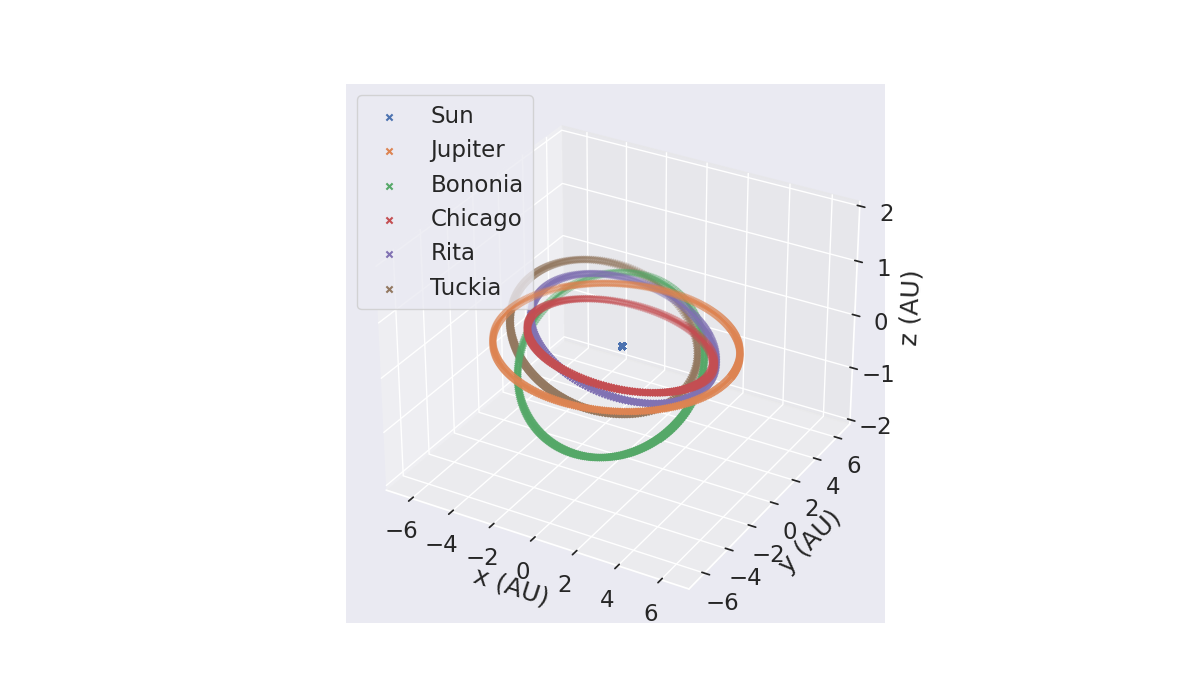

In [182]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    

fig = plt.figure(figsize=(12,7))

ax = plt.axes(projection='3d')
#ax = fig.add_subplot(111, projection='3d')

for object_index in range(len(object_list)):    
        ax.scatter3D(x_pos[object_index], y_pos[object_index], z_pos[object_index], marker='x');
    
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')
ax.set_zlabel('z (AU)')
ax.set_xlim(-7, 7); ax.set_ylim(-7, 7); ax.set_zlim(-2, 2);
ax.legend(object_list, loc='upper left')


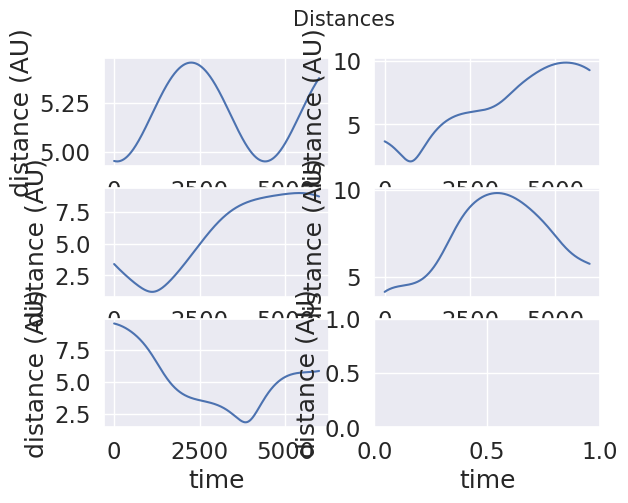

In [192]:
fig, axs = plt.subplots(3,2)

fig.suptitle('Distances', fontsize=15)
distance = np.sqrt(np.square(x_pos[0]-x_pos[1]) + np.square(y_pos[0]-y_pos[1]) + np.square(z_pos[0]-z_pos[1]))
axs[0,0].plot(times, distance)

distance = np.sqrt(np.square(x_pos[1]-x_pos[2]) + np.square(y_pos[1]-y_pos[2]) + np.square(z_pos[1]-z_pos[2]))
axs[0,1].plot(times, distance)

distance = np.sqrt(np.square(x_pos[1]-x_pos[3]) + np.square(y_pos[1]-y_pos[3]) + np.square(z_pos[1]-z_pos[3]))
axs[1,0].plot(times, distance)

distance = np.sqrt(np.square(x_pos[1]-x_pos[4]) + np.square(y_pos[1]-y_pos[4]) + np.square(z_pos[1]-z_pos[4]))
axs[1,1].plot(times, distance)

distance = np.sqrt(np.square(x_pos[1]-x_pos[5]) + np.square(y_pos[1]-y_pos[5]) + np.square(z_pos[1]-z_pos[5]))
axs[2,0].plot(times, distance)

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='distance (AU)')


https://www.nigiara.it/matematica/vettori/come-calcolare-langolo-tra-due-vettori.htm#:~:text=Come%20si%20calcola%20l'angolo%20tra%20i%20vettori%3F,compreso%20tra%20i%20due%20vettori.&text=Quindi%2C%20l'angolo%20alfa%20%C3%A8,prodotto%20dei%20moduli%20dei%20vettori.

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

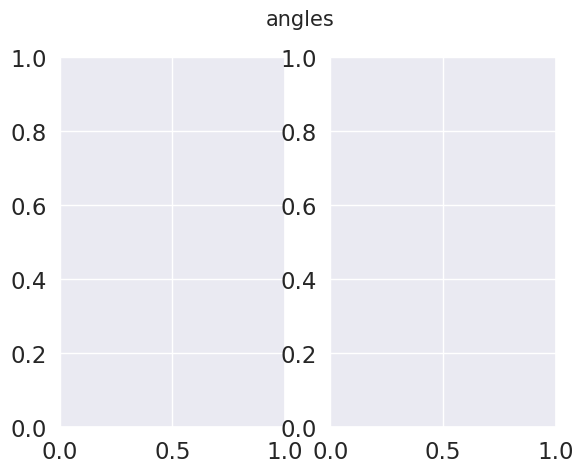

In [210]:
import math 
def angle_of_vectors(a,b,c,d):    
    dotProduct = a*c + b*d
    # for three dimensional simply add dotProduct = a*c + b*d  + e*f 
    modOfVector1 = math.sqrt( a*a + b*b)*math.sqrt(c*c + d*d) 
    # for three dimensional simply add modOfVector = math.sqrt( a*a + b*b + e*e)*math.sqrt(c*c + d*d +f*f) 
    angle = dotProduct/modOfVector1
    #print("Cosθ =",angle)
    angleInDegree = math.degrees(math.acos(angle))
    #print("θ =",angleInDegree,"°")
     
# angle_of_vectors(a,b,c,d)  (a,b) (c,d)

fig2, axs2 = plt.subplots(1,2)

fig2.suptitle('angles', fontsize=15)

angle = [0] * 40

for sng in range (40):
    angle [sng] = angle_of_vectors (x_pos[2][sng], y_pos[2][sng], x_pos[1][sng], y_pos[1][sng])
    print (angle [sng])
axs2[0,0].plot(times, angle)
#print(x_pos[2][1])


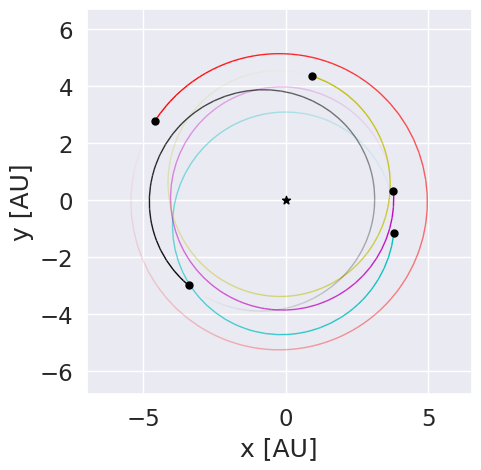

In [189]:
%matplotlib inline
fig = rebound.OrbitPlot(sim, unitlabel="[AU]",color=True)

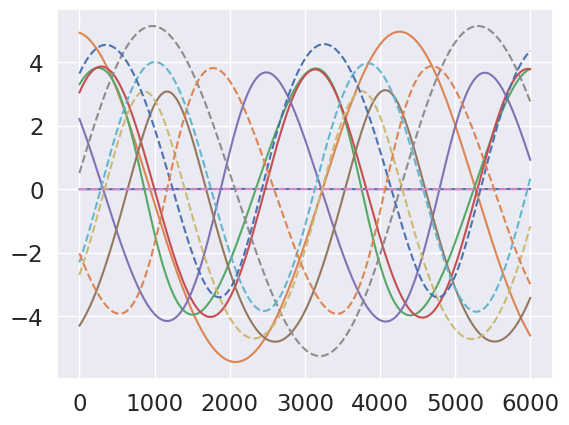

In [190]:
plt.plot(times, x_pos.T)
plt.plot(times, y_pos.T,'--')
plt.show()

In [50]:
%reset
sim = rebound.Simulation()

sim.units = ['mearth','day','AU']
sim.add('Sun')
sim.add('Jupiter') 
sim.add('Venusia') 

#sim.add(m=4000)
#sim.add(m=0.25, P=5,e=0.04) 

N_output = 1000
x_pos=np.empty((2,N_output))
y_pos=np.empty((2,N_output))

times = np.linspace(0,1000,num=N_output) #integrate a day
#sim.move_to_com() 
for i,t in enumerate (times):
    sim.integrate(t)
    x_pos[0,i] =sim.particles[0].x
    y_pos[0,i] =sim.particles[0].y
    x_pos[1,i] =sim.particles[1].x
    y_pos[1,i] =sim.particles[1].y
    #x_pos[2,i] =sim.particles[2].x
    #y_pos[2,i] =sim.particles[2].y

plt.scatter(x_pos, y_pos)
plt.show()

#tot=0
#for name in MPC_Jupyter_no_outliers['Name']:
#    if (str(name) != 'nan'):
#        sim.add(name)
#        tot = tot +1
#    if (tot > 5):
#        break


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/home/alfumaga2001/.local/lib/python3.8/site-packages/matplotlib/animation.py:879: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Venusia'... 
Found: 499 Venusia (A902 YE) 


NameError: name 'np' is not defined

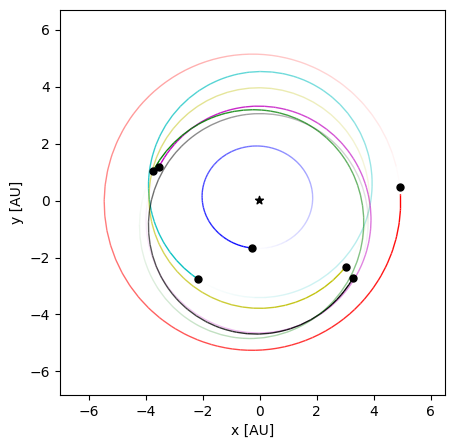

In [27]:
%matplotlib inline
fig = rebound.OrbitPlot(sim, unitlabel="[AU]",color=True)

In [39]:
#remove main belt asteroid
MPC = df.apply(lambda row: row[~df['Orbit_type'].isin(['MBA'])])
MPC = df.apply(lambda row: row[~df['Orbit_type'].isin(['Hilda'])]) #Jupyter asteroids
MPC = df.apply(lambda row: row[~df['Orbit_type'].isin(['Jupiter Trojan'])]) #Jupyter asteroids

In [59]:
#different orbit type for all MPC object
MPC.Orbit_type.unique()

array(['MBA', 'Phocaea', 'q < 1.665 a.u.', 'Hilda', 'Amor', 'Hungaria',
       'Apollo', 'Distant Object', 'Aten', 'Atira'], dtype=object)

In [37]:
#filter on orbital parameter 
MPC_orbit = MPC.filter(['i','e','a','q','Q','Orbit_type','Hex_flags'], axis=1)

In [38]:
print(MPC_orbit[["Hex_flags"]].value_counts())

Hex_flags
0            113679
1              2293
dtype: int64


Text(0, 0.5, 'MPC Count')

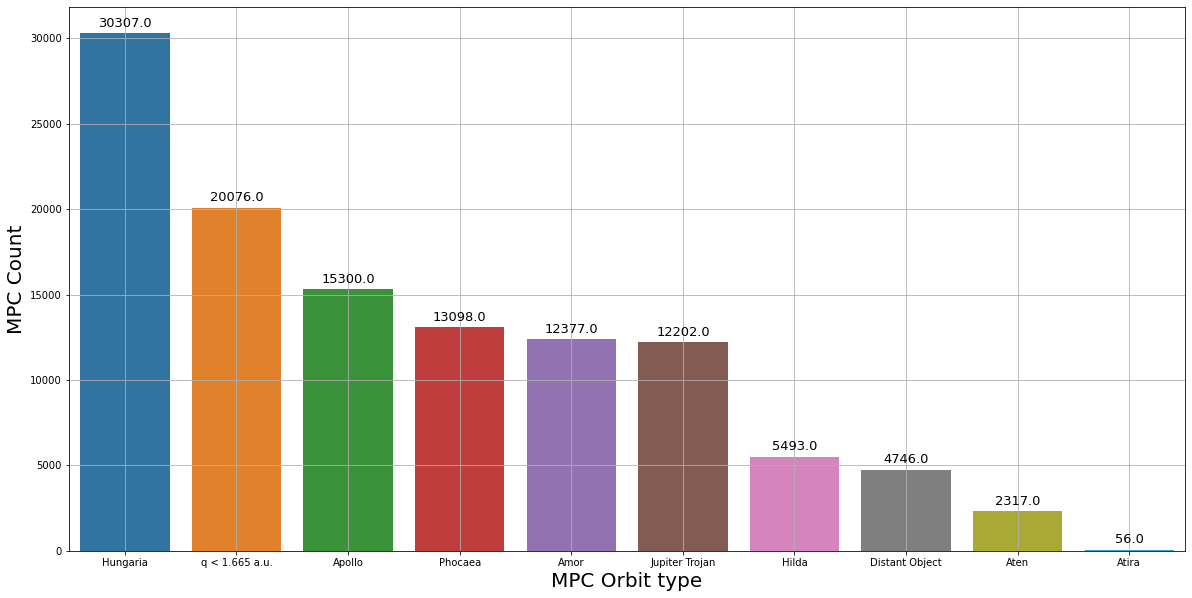

In [22]:
plt.figure(figsize=(20, 10))
splot=sns.countplot(x="Orbit_type", data=MPC_orbit, orient='h', order = MPC_orbit['Orbit_type'].value_counts().index)
plt.grid()
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=13,
                   xytext = (0, +10), 
                   textcoords = 'offset points')
plt.xlabel("MPC Orbit type", size=20)
plt.ylabel("MPC Count", size=20)

In [184]:
NEO = new_df.apply(lambda row: row[new_df['Orbit_type'].isin(['Apollo','Amor','Aten','Atira'])])

In [23]:
MPC_orbit_pha = MPC_orbit[MPC_orbit['Hex_flags'] == 1] 

Text(0, 0.5, 'PHA Count')

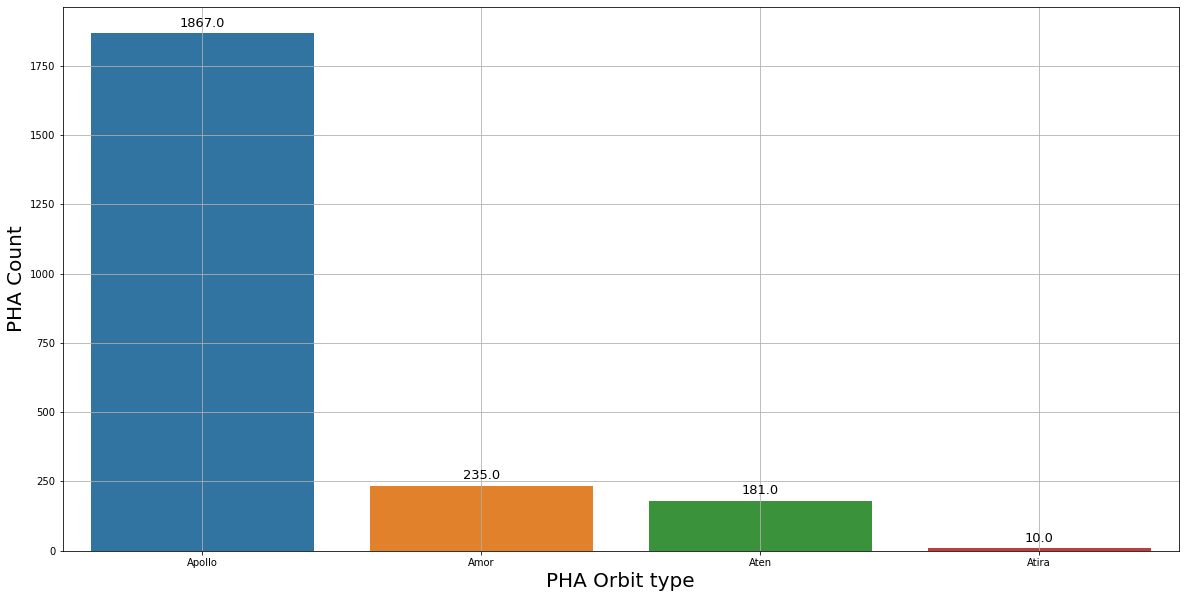

In [24]:
plt.figure(figsize=(20, 10))
splot=sns.countplot(x="Orbit_type", data=MPC_orbit_pha, orient='h', order = MPC_orbit_pha['Orbit_type'].value_counts().index)
plt.grid()

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=13,
                   xytext = (0, +10), 
                   textcoords = 'offset points')
plt.xlabel("PHA Orbit type", size=20)
plt.ylabel("PHA Count", size=20)
#plt.savefig("number_objet_type.png")

Text(0, 0.5, 'PHA Count')

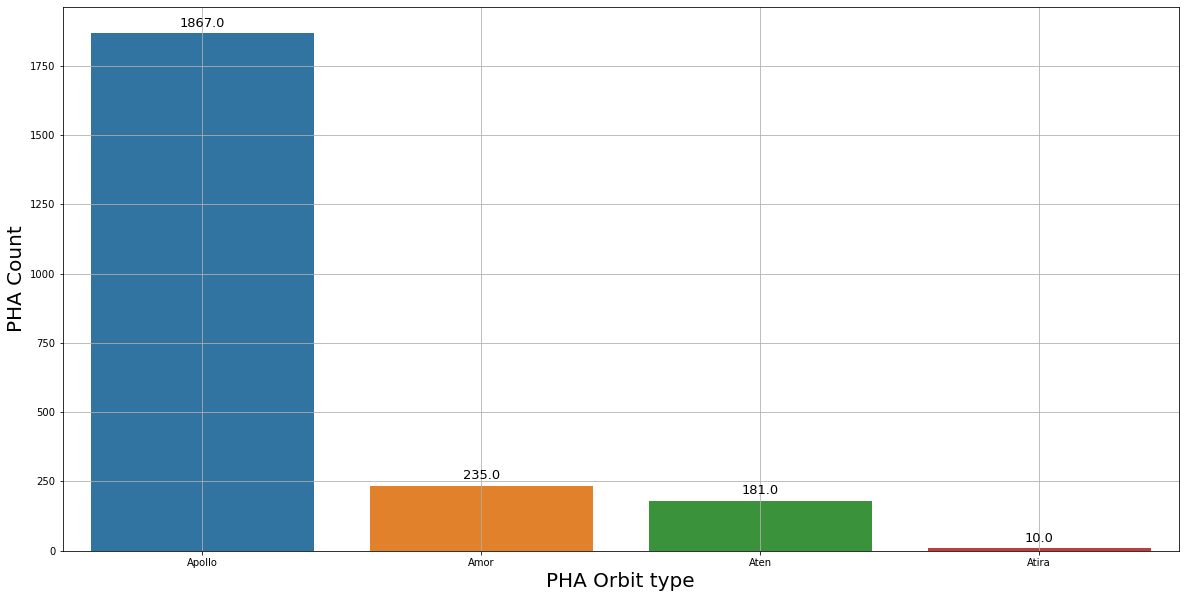

In [26]:
plt.figure(figsize=(20, 10))
splot=sns.countplot(x="Orbit_type", data=MPC_orbit_pha, orient='h', order = MPC_orbit_pha['Orbit_type'].value_counts().index)
plt.grid()

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=13,
                   xytext = (0, +10), 
                   textcoords = 'offset points')
plt.xlabel("PHA Orbit type", size=20)
plt.ylabel("PHA Count", size=20)
#plt.savefig("number_objet_type.png")

In [185]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [53]:
NEO.head()

,i,e,a,q,Q,Orbit_type
432,10.82796,0.222733,1.458150,1.133372,1.782929,Amor
718,11.57596,0.546982,2.636929,1.194576,4.079281,Amor
886,9.39501,0.570579,2.472767,1.061858,3.883676,Amor
1035,26.68199,0.533102,2.665942,1.244722,4.087161,Amor
1220,11.88330,0.435880,1.918933,1.082509,2.755356,Amor


In [186]:
numeric_cols = NEO.select_dtypes(include = [np.number]).columns
abs_z_scores=np.abs(NEO[numeric_cols].apply(zscore)<3)
abs_z_scores['Orbit_type'] = np.where(1 == 1, True, False)

In [187]:
NEO_no_outliers=NEO[abs_z_scores]

In [190]:
param_orbit = {
    'i': 'Inclination (degree)',
    'e': 'Eccentricity',
    'a': 'Semi-major axis (a.u.)',
    'q': 'Perihelion distance (a.u.)',
    'Q': 'Aphelion distance (a.u.)'
}
#range_orbit = {}
#for column in param_orbit.keys():
#    df_orbit =Q_Greater_one[[column, "Orbit_type"]].groupby(['Orbit_type']).max()
#    param = df_orbit.to_dict('dict')
#    for key, values in param.items():
#        range_orbit[key] = values

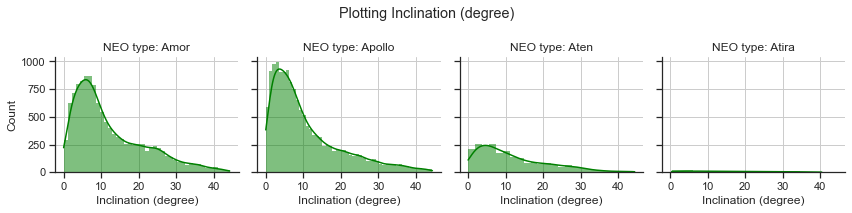

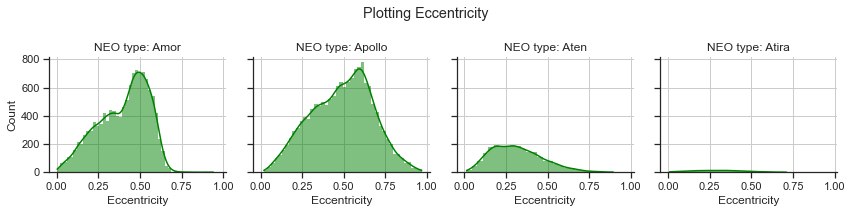

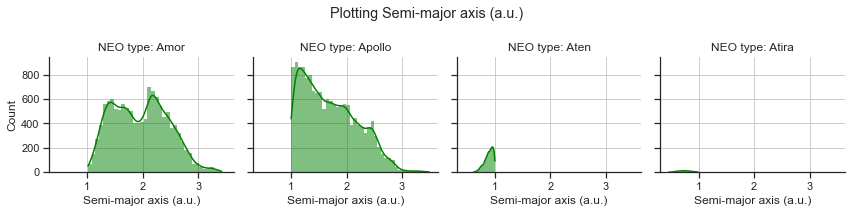

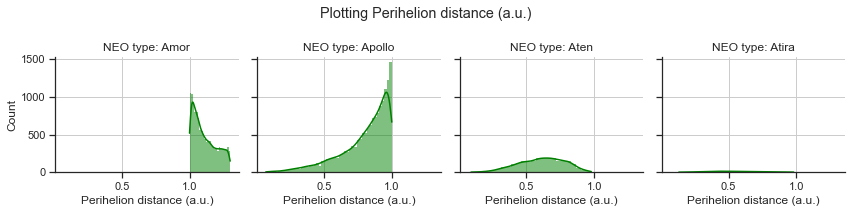

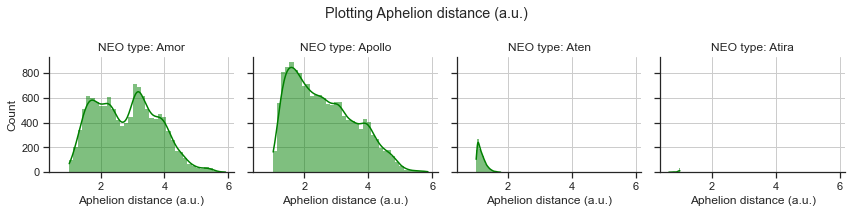

In [192]:
for key, values in param_orbit.items():
    sns.set_style("ticks",{'axes.grid' : True})
    g = sns.FacetGrid(NEO_no_outliers, col="Orbit_type", margin_titles=True)
    g.fig.suptitle('Plotting '+ values)      
    g.map_dataframe(sns.histplot, key, color="green",  kde=True, linewidth=0)
    g.set_xlabels(values)
    g.set_ylabels(label='Count')
    g.set_titles(col_template="NEO type: {col_name}", row_template="{row_name}")
    g.tight_layout()